# Problem description

Cross-lingual document classification (CLDC) is the text mining problem where we are given:
- labeled documents for training in a source language $\ell_1$, and 
- test documents written in a target language $\ell_2$. 

For example, the training documents are written in English, and the test documents are written in French. 


CLDC is an interesting problem. The hope is that we can use resource-rich languages to train models that can be applied to resource-deprived languages. This would result in transferring knowledge from one language to another. 
There are several methods that can be used in this context. In this workshop we start from naive approaches and progressively introduce more complex solutions. 

The most naive solution is to ignore the fact the training and test documents are written in different languages.  

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from prettytable import PrettyTable


import sys
sys.path.append("..")

from collections import Counter
from src.models import *
from src.utils import *
from src.dataset import *


/home/ipartalas/projects/LASER/


<img src="../data/images/classes.png">

1. Dataset: holds the data of sources and target language
2. System: This is a set of steps: Does fit, predict. Can be in the form of a pipeline also
3. Experiment: Given a Dataset and a System it fits, predicts and reports evaluation scores

For this workshop we will use a dataset from the [SemEval](http://alt.qcri.org/semeval2015/) workshop for the Sentiment Analysis task. While the tasks have three classes, that is **Positive, Negative, Neutral**, we will use only two classes in order to simplify it. So, let's load the data for a pair of languages and check a few statistics.

In [11]:
exp = Dataset("../data/datasets/","en", "tr")
exp.load_data()
exp.load_cl_embeddings("../",300,False)



Training data
Training Data Shape:  (1635, 2)
Class distribution:  {'positive': 1114, 'negative': 521}

Training data
Training Data Shape:  (1008, 2)
Class distribution:  {'positive': 573, 'negative': 435}
Loaded 3097 vectors
Loaded 727 vectors


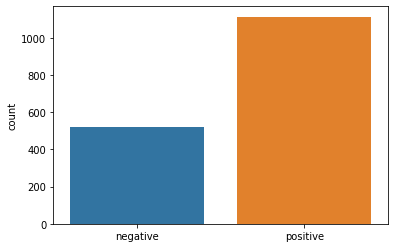

In [12]:
# Plot the counts on the classes for the source language
sns.countplot(exp.y_train)

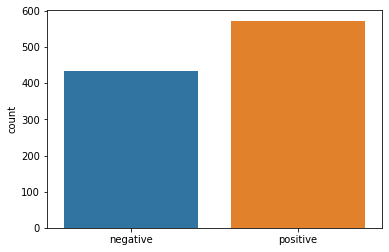

In [13]:
# And for the Spanish dataset
sns.countplot(exp.y_test,order=["negative","positive"])

Observe that the datasets are unbalanced as we have much more positive comments that negative ones. We will start by establishing a few baselines and see how we can improve over them by leveraging cross-lingual word embeddings. We will start with a dummy classifier that will respect the distribution of the classes to generate some random predictions. 

In [14]:
# Let's keep the scores of all the expriments in a table
x = PrettyTable()

x.field_names = ["Model", "f-score"]

# Majority Class
pipeline = Pipeline([('vectorizer', CountVectorizer()), 
                     ('classifier', DummyClassifier("stratified"))])
runner = Runner(pipeline, exp)
score = runner.eval_system()
x.add_row(["Dummy", format_score(score)])
print(x)

+-------+---------+
| Model | f-score |
+-------+---------+
| Dummy |  59.38  |
+-------+---------+


In [15]:
# Logistic Regression on words
pipeline = Pipeline([('vectorizer', CountVectorizer(lowercase=True)), 
                     ('classifier', LogisticRegression(solver="lbfgs"))])
runner = Runner(pipeline, exp)
score = runner.eval_system()
x.add_row(["LR unigrams",format_score(score)])
print(x)

+-------------+---------+
|    Model    | f-score |
+-------------+---------+
|    Dummy    |  59.38  |
| LR unigrams |  72.49  |
+-------------+---------+


Let's see now how we can leverage the cross-lingual word embeddings in order to perform zero-shot learning. A simple but effective baseline consists of averaging the word embeddings in each document in order to come up with a document (or sentence) representation. We will do that by using a look-up table in order to pull the appropriate cross-linual word embeddings for each document as it is shown in the diagram:

![](../data/images/vec_average.png)

As we saw during the introduction we use a binary representation for the document terms which we use to perform a look-up in the embeddings matrix of size $V\times d$, where $V$ is the size of the vocabulary and $d$ the dimension of the latent space, and pull the vectors. In the example we will pull three vectors. Finally, we will just calculate our document vector by just averaging the vectors. We will repeat this operation for each document in both the target and the source languages. Then we will follow the zero-shot learning framework and we will train a classifier on the source language and predict on the target language.

In [16]:
for name, myclf in zip(['Knn-nBow', 'LR-nBow'],[KNeighborsClassifier(n_neighbors=2), LogisticRegression(C=10, solver="lbfgs")]):

    avg_baseline = nBowClassifier(myclf,exp.source_embeddings,exp.target_embeddings)

    pipeline = Pipeline([('vectorizer', CountVectorizer(lowercase=True,vocabulary=exp.vocab_)), 
                         ('classifier', avg_baseline)])

    runner = Runner(pipeline, exp)
    x.add_row([name, format_score(runner.eval_system())])
    

In [17]:
print(x)

+-------------+---------+
|    Model    | f-score |
+-------------+---------+
|    Dummy    |  59.38  |
| LR unigrams |  72.49  |
|   Knn-nBow  |  65.45  |
|   LR-nBow   |  73.66  |
+-------------+---------+


In the following model we will use the LASER representations in order to train the classifiers.

In [18]:
for name, myclf in zip(['Knn-laser', 'LR-laser'],[KNeighborsClassifier(n_neighbors=2), LogisticRegression(C=10, solver="lbfgs")]):
    laser_clf = LASERClassifier(myclf, exp.source_lang, exp.target_lang)
    pipeline = Pipeline([("doc2laser",Doc2Laser()),('classifier', laser_clf)])
    pipeline.set_params(doc2laser__lang=exp.source_lang)
    pipeline.fit(exp.train,exp.y_train)
    runner = Runner(pipeline, exp)

    pipeline.set_params(doc2laser__lang=exp.target_lang)
    x.add_row([name, format_score(runner.eval_system(prefit=True))])

 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language en  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 1635 sentences in 6s
 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language tr  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 1008 sentences in 6s
 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language en  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 1635 sentences in 7s
 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language tr  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 1008 sentences in 5s


In [19]:
print(x)

+-------------+---------+
|    Model    | f-score |
+-------------+---------+
|    Dummy    |  59.38  |
| LR unigrams |  72.49  |
|   Knn-nBow  |  65.45  |
|   LR-nBow   |  73.66  |
|  Knn-laser  |  72.61  |
|   LR-laser  |  80.86  |
+-------------+---------+


We observe that the zero-shot learning using LASER representations can achieve state-of-the-art results. 

***Exercises:*** 

* Use other pairs of languages and see the performance. For example, you can try to transfer from more distant languages like Russian.
* Write a function in order to calculate all the pairs of (source,target) languages and compare the results.
* Tune the classifier or use other type of models